# Reduced coverage experiments
Where the set of entries contrained in one thesaurus is constrained to match another, smaller thesaurus. This lets us look at performance differences due to 

 - higher coverage of space of all words/phrases (due to different filtering or algorithm specifics), versus 
 - better vector quality
 
There are currently (19-5-15) two sets of such experiments, both for NPs only:
 - w2v vectors reduced to the coverage of count-windows vectors
 - count-windows reduced to coverage of Baroni vector

In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from copy import deepcopy
from notebooks.common_imports import *
from gui.output_utils import *
from gui.user_code import pretty_names
from pprint import pprint

sns.timeseries.algo.bootstrap = my_bootstrap
sns.categorical.bootstrap = my_bootstrap

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


In [2]:
def plot_matching(exp_with_constraints, labels=None, rotation=0):
    matching = []
    for e in exp_with_constraints:
        settings = settings_of(e.id)
        settings['expansions__entries_of_id'] = None
        matching.append(Experiment.objects.get(**settings))
    
    ids1 = list(exp_with_constraints.values_list('id', flat=True))
    ids2 = [x.id for x in matching]
    print(ids1, '--->', ids2)
    if not labels:
        labels = ['%s-%s'%(a.id, b.id) for a,b in zip(exp_with_constraints, matching)]
    diff_plot_bar([ids1, ids2], ['Limited', 'Unlimited'],
                  labels, rotation=rotation, hue_order=['Unlimited', 'Limited'])

# count windows vectors (add, mult, ...) reduced to Baroni's coverage
we know they are better and have a higher coverage, so can reducing the coverage reduce the accuracy too

[216, 218, 220, 222] ---> [27, 28, 29, 30]


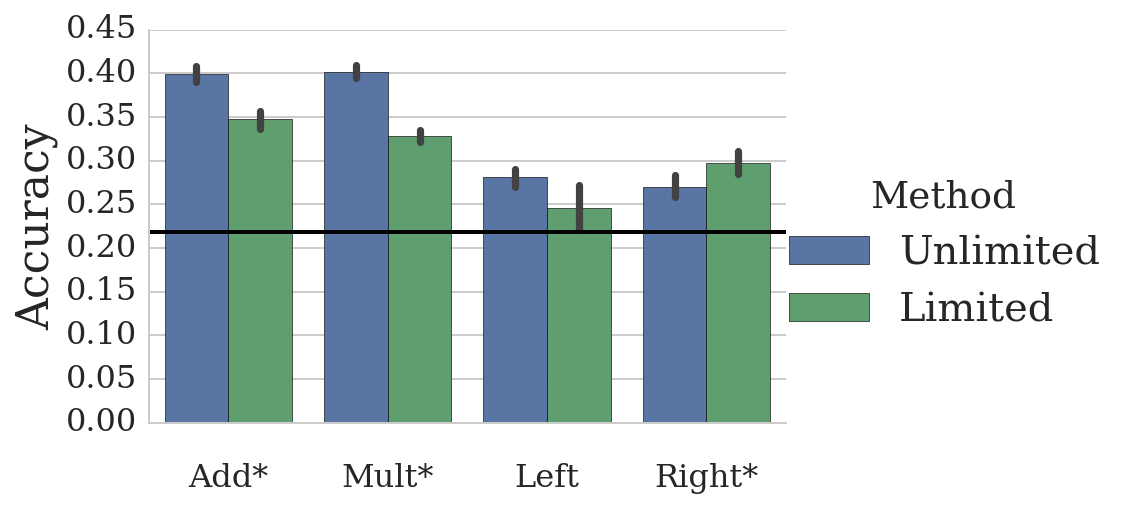

In [3]:
experiments = Experiment.objects.filter(expansions__entries_of__isnull=False, 
                                        expansions__entries_of__composer='Baroni')
names = [n.expansions.vectors.composer for n in experiments]

plot_matching(experiments, labels=names)
plt.axhline(random_vect_baseline(), c='k');
plt.savefig('plot-reduced-coverage1.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# word2vec reduced to coverage of count windows (there shouldn't be a large difference)

[215, 217, 219, 221] ---> [34, 35, 36, 37]


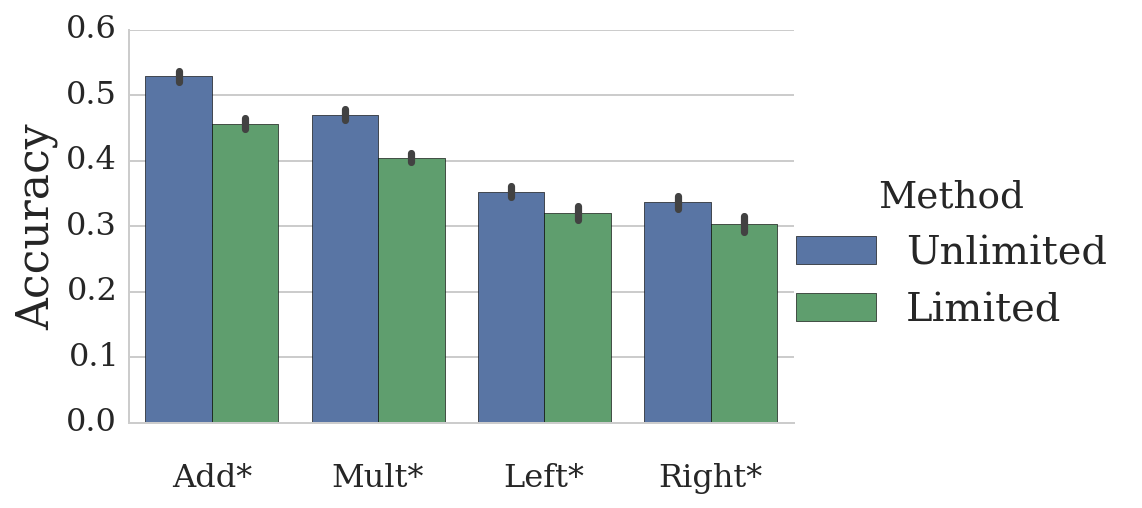

In [4]:
exp_ids = Experiment.objects.filter(expansions__entries_of__isnull=False,
                                    expansions__entries_of__algorithm='count_windows'
                                   ).exclude(expansions__entries_of__composer='Baroni')
names = [n.expansions.vectors.composer for n in exp_ids]
plot_matching(exp_ids, labels=names)
# plt.axhline(random_vect_baseline(), c='k');
plt.savefig('plot-reduced-coverage2.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# wiki-100 reduced to coverage of wiki-15 

[310, 311, 312, 313] ---> [34, 35, 36, 37]


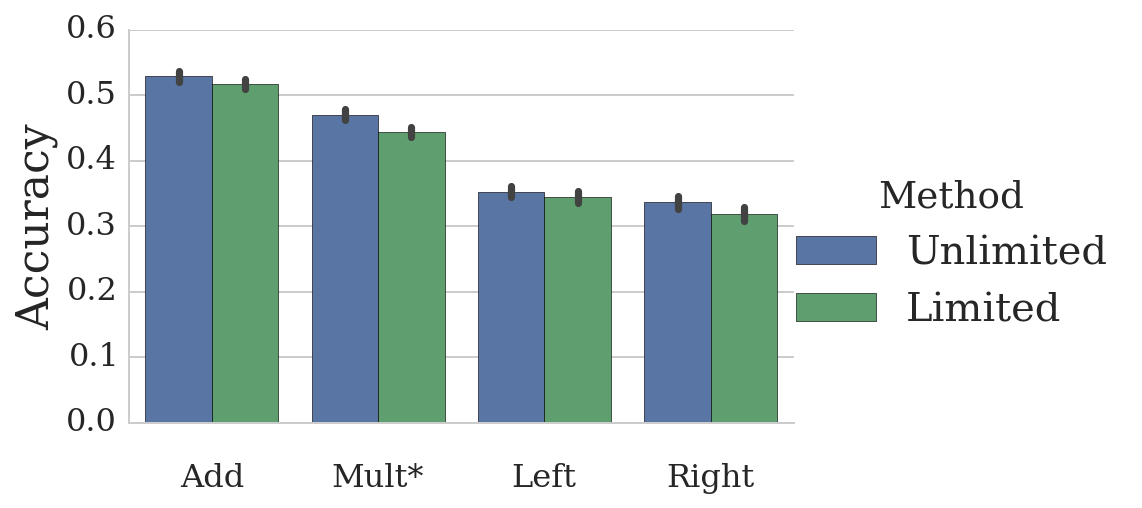

In [5]:
exp_ids = Experiment.objects.filter(expansions__entries_of__isnull=False,
                                    expansions__vectors__unlabelled_percentage=100,
                                    expansions__entries_of__unlabelled_percentage=15)
names = [n.expansions.vectors.composer for n in exp_ids]
plot_matching(exp_ids, labels=names)
# plt.axhline(random_vect_baseline(), c='k');
plt.savefig('plot-reduced-coverage3.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Learning curve with reduced coverage
An extended version of the above cell

In [6]:
constrained_exp_ids = Experiment.objects.filter(expansions__entries_of__isnull=False,
                                    expansions__entries_of__unlabelled_percentage__in=[1, 10, 15, 20],
                                    expansions__vectors__composer='Add').values_list('id', flat=True)
print(constrained_exp_ids)

[310, 334, 335, 336, 337, 338, 339, 340, 341, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, '...(remaining elements truncated)...']


In [7]:
unconstrained_exp_ids = []
unconstrained_exp_ids = set()
for eid in constrained_exp_ids:
    s = settings_of(eid)
    s['expansions__entries_of_id'] = None
    del s['expansions__vectors__unlabelled_percentage']
    unconstrained_exp_ids.update(set(Experiment.objects.filter(**s).values_list('id', flat=True)))
print(unconstrained_exp_ids, '-->', constrained_exp_ids)

{87, 34, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122} --> [310, 334, 335, 336, 337, 338, 339, 340, 341, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, '...(remaining elements truncated)...']


In [8]:
names = {'percent':'expansions__vectors__unlabelled_percentage',
         'reduced_to':'expansions__entries_of__unlabelled_percentage'}
df1 = dataframe_from_exp_ids(unconstrained_exp_ids, names)
# df1['kind'] = 'Unlimited'
df2 = dataframe_from_exp_ids(constrained_exp_ids, names)
# df2['kind'] = 'Limited'

folds has 6000 values
percent has 6000 values
Accuracy has 6000 values
reduced_to has 6000 values
Calculating CI for exp 352
Calculating CI for exp 353
Calculating CI for exp 354
Calculating CI for exp 355
Calculating CI for exp 356
Calculating CI for exp 357
Calculating CI for exp 358
Calculating CI for exp 359
Calculating CI for exp 360
Calculating CI for exp 361
Calculating CI for exp 362
Calculating CI for exp 363
Calculating CI for exp 364
Calculating CI for exp 365
Calculating CI for exp 366
Calculating CI for exp 367
Calculating CI for exp 368
Calculating CI for exp 369
Calculating CI for exp 370
Calculating CI for exp 371
Calculating CI for exp 372
Calculating CI for exp 373
Calculating CI for exp 374
Calculating CI for exp 375
folds has 16500 values
percent has 16500 values
Accuracy has 16500 values
reduced_to has 16500 values


In [9]:
df = pd.concat([df1, df2], ignore_index=True).convert_objects(convert_numeric=True).fillna(100)

In [19]:
df[df.folds==0]

,Accuracy,folds,percent,reduced_to
0,0.381975,0,15,100
500,0.516067,0,100,100
1000,0.270539,0,1,100
1500,0.364798,0,10,100
2000,0.399490,0,20,100
2500,0.410679,0,30,100
3000,0.432772,0,40,100
3500,0.435168,0,50,100
4000,0.435816,0,60,100
4500,0.441499,0,70,100


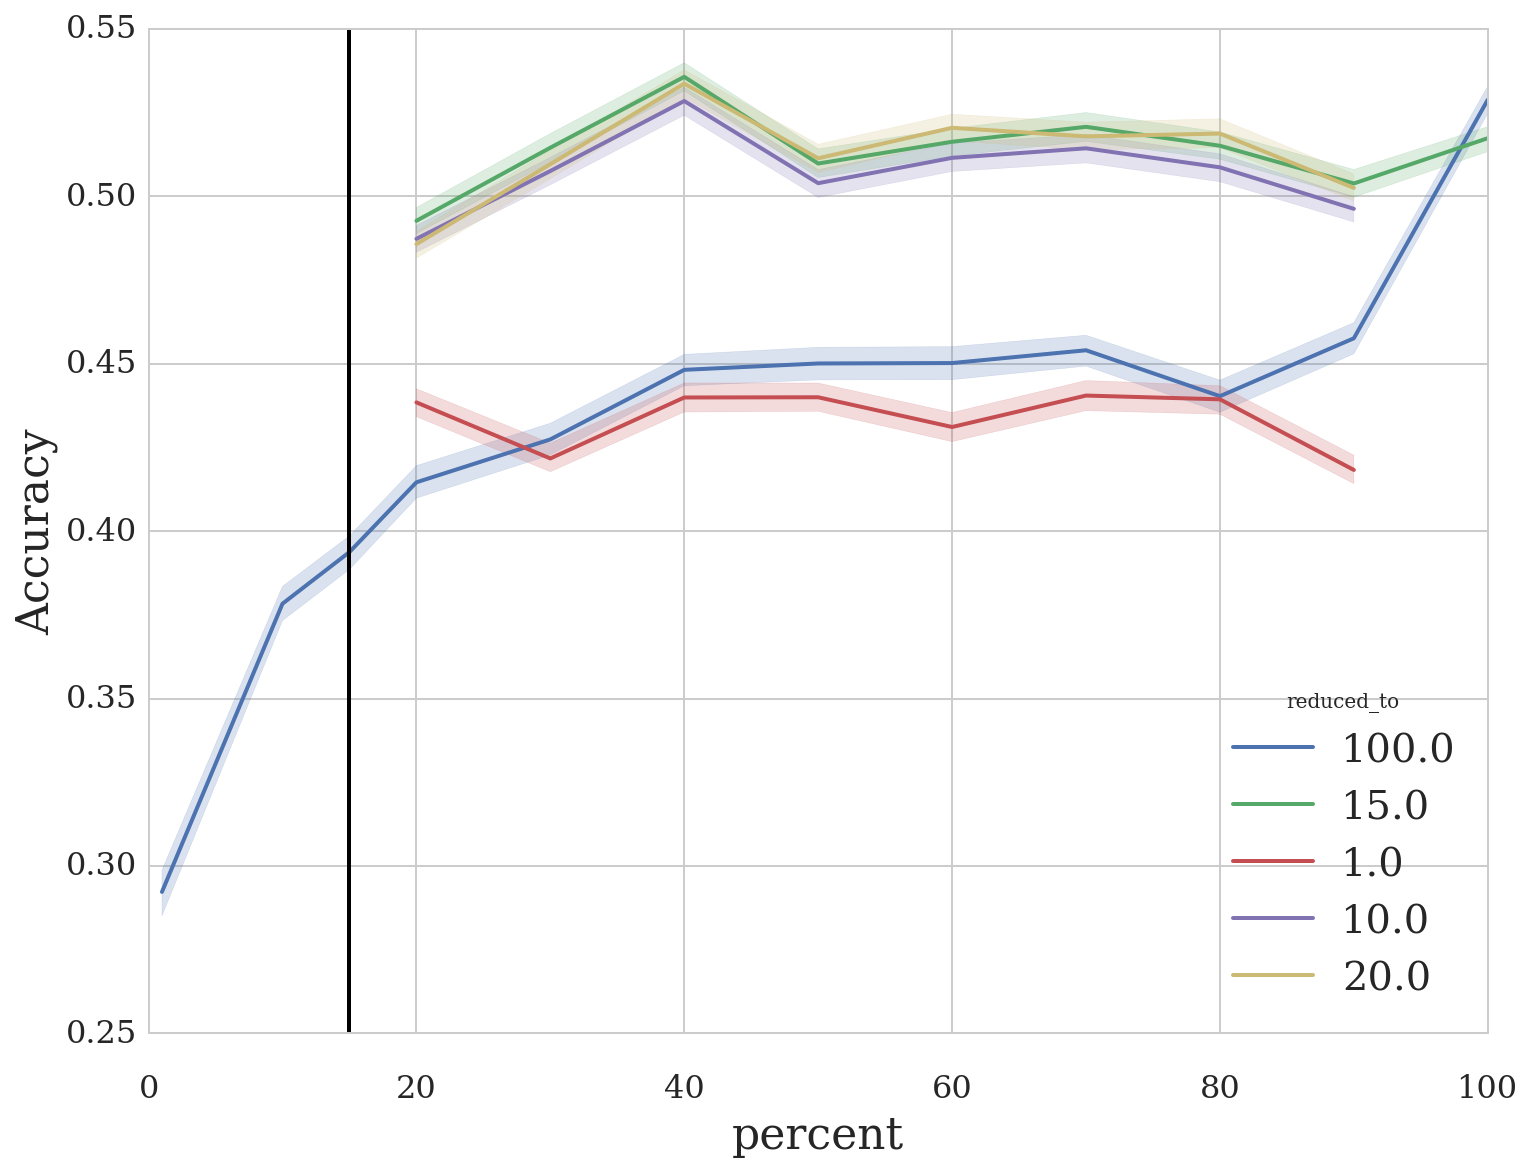

In [11]:
ax = sns.tsplot(df, time='percent', unit='folds', condition='reduced_to', value='Accuracy')
plt.xlim(0, 100)
plt.axvline(15, c='k');

# TODO
turn plot sideways, percent reduced to on x axis, condition=perdent reduced from

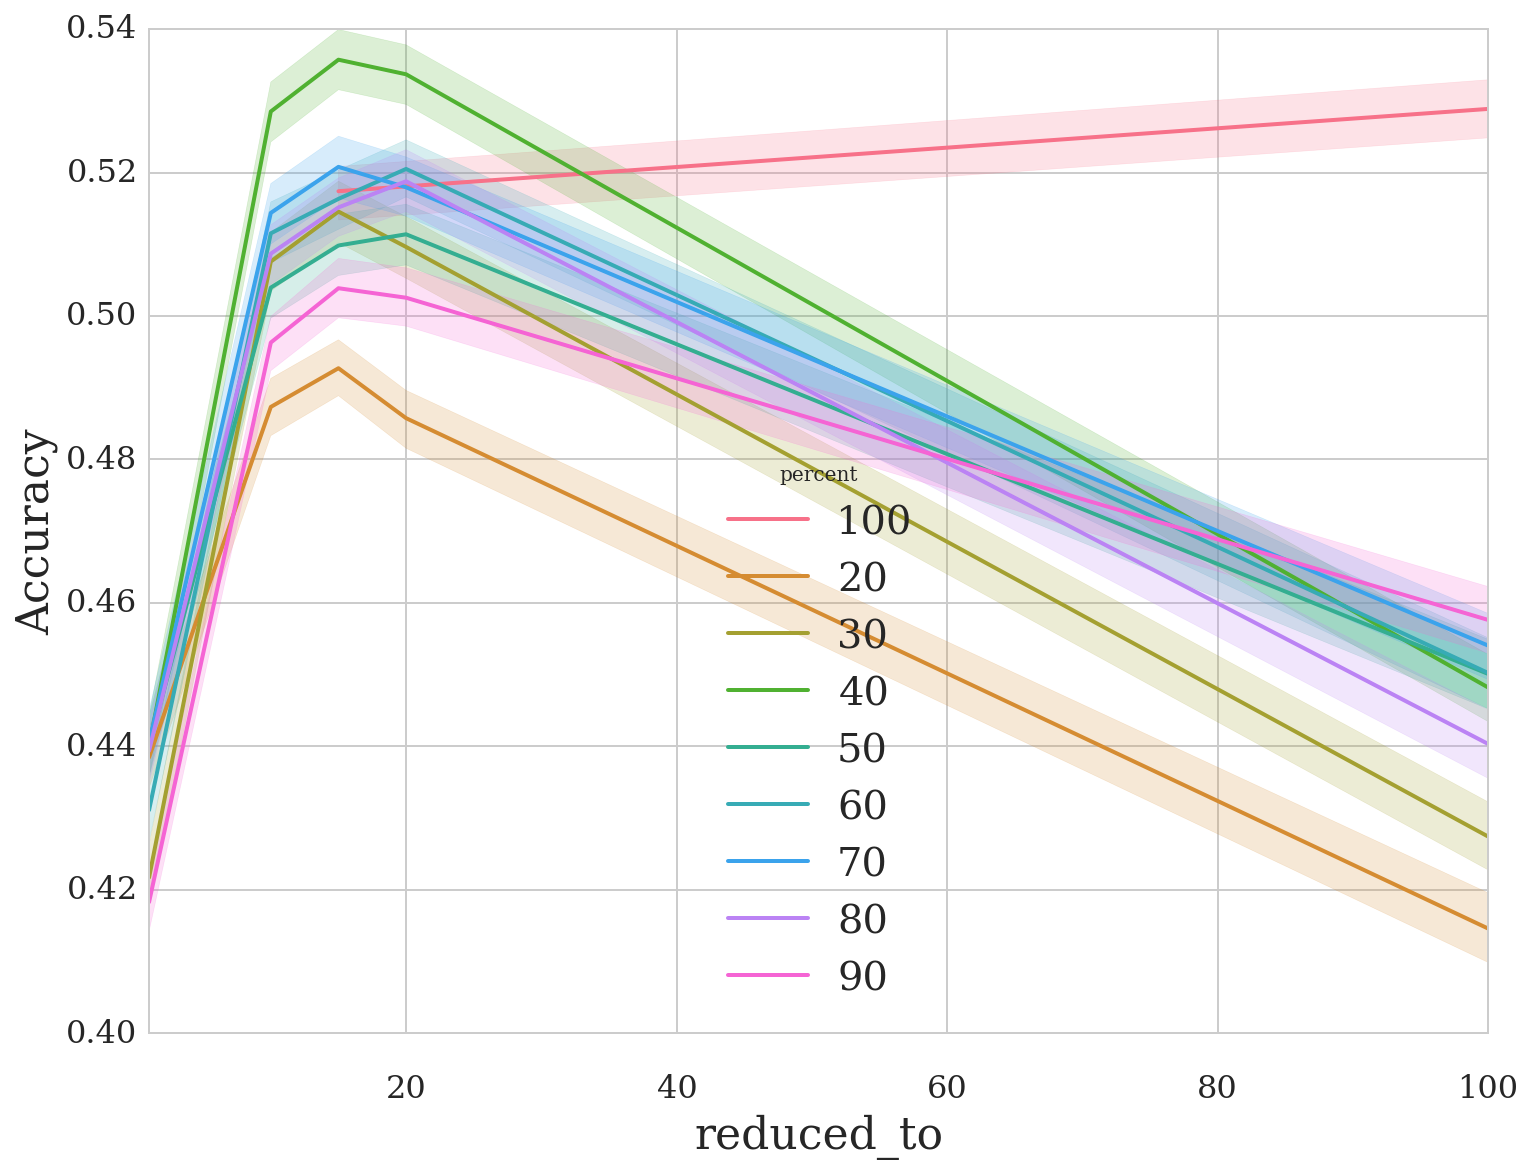

In [20]:
sns.tsplot(df[df.percent > 15], value='Accuracy', time='reduced_to', unit='folds', condition='percent')

In [33]:
Experiment.objects.filter(expansions__vectors__unlabelled_percentage=20,
                       expansions__entries_of__unlabelled_percentage=20)

[<Experiment: Experiment object>]

In [34]:
s = settings_of(368)
s['expansions__entries_of_id'] = None
Experiment.objects.get(**s).id

115